# compensating saturated pulses

## Intro

orthogonal decomposition for recovering linear behavior from saturated pulses

## Loading Libraries

In [1]:
from pylab import *
import h5py
from scipy.optimize import curve_fit
#from scipy.stats import binned_statistic_dd
from scipy.stats import binned_statistic_dd
from scipy import optimize
import pickle
from scipy import stats
from scipy.stats.mstats import theilslopes
from scipy.signal import medfilt
from scipy.signal import savgol_filter
import os

## Initializing Data

### Loading Data

In [4]:
apd_traces =[]

apd_traces_file = open("apdtraces_run166.dat")
for i in range(1000):
    line_data = [float(i) for i in apd_traces_file.readline().split(" ")]
    line_data-=mean(line_data[:25])
    apd_traces.append(line_data)

apd_traces = array(apd_traces)
apd_traces_file.close()

In [5]:
mcp_traces =[]

mcp_traces_file = open("mcptraces_run166.dat")
for i in range(1000):
    line_data = [float(i) for i in mcp_traces_file.readline().split(" ")]
    line_data-=mean(line_data[:25])
    mcp_traces.append(line_data)

mcp_traces = array(mcp_traces)
mcp_traces_file.close()

## Visualizing Some Sample Data from the high speed digitizer (hsd)

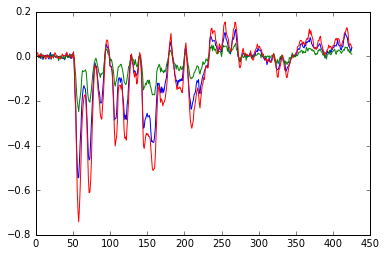

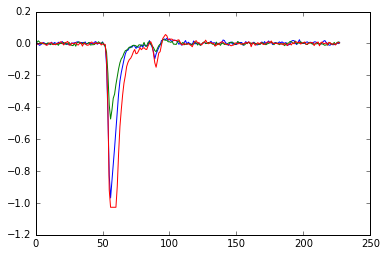

In [6]:
plot(mcp_traces[0])
plot(mcp_traces[400])
plot(mcp_traces[800])
show()

plot(apd_traces[0])
plot(apd_traces[400])
plot(apd_traces[800])
show()

#### aligning waveforms

In [7]:
ch1_waves = 0+apd_traces
temp = ch1_waves[0]
for i in ch1_waves:
    #shift_amount = 6352-argmax(convolve(ch1_waves[0],i))+100
    shift_amount = 75-argmax(convolve(diff(ch1_waves[0]),diff(i)))+100
    temp = vstack([temp,append(zeros(shift_amount),i[:-shift_amount])])

temp =temp[1:]
    

In [8]:
ch1_waves = temp

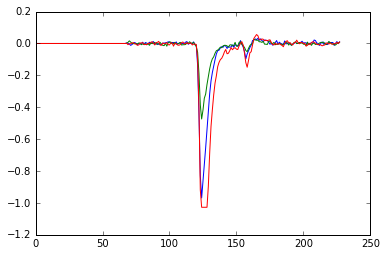

In [9]:
plot(ch1_waves[0])
plot(ch1_waves[400])
plot(ch1_waves[800])
#xlim(115,130)
show()

#### identifying saturated waveforms

In [10]:
non_saturated_pulses = array([(0.8>max(abs(i)) and 0.3<max(abs(i))) for i in ch1_waves])

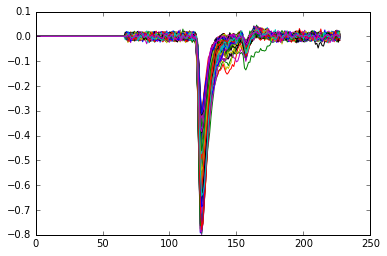

In [11]:
for i in ch1_waves[non_saturated_pulses]:
    plot(i)
show()

### Calculating Eiegen Waveform using SVD on manually selected non-saturated peaks

In [12]:
##############################
##############################
#singular value decomposition on background shots. variable v contains the eigen backgrounds
#u,s,v = svd(ch0_waves) don't use this. it will crash computer unless a small section of the waveforms is chosen
##############################
##############################


#instead manually calculate svd by using the smaller lh sv.
s,u = eig(dot(ch1_waves[non_saturated_pulses],ch1_waves[non_saturated_pulses].transpose()))
v = dot(pinv(u),ch1_waves[non_saturated_pulses])



In [13]:
temp = array([i/dot(i,i)**0.5 for i in v[:25]])#normalizing
v = real(temp)
print(dot(v[0],v[0])) #validating orthogonality
print(dot(v[1],v[1])) #validating orthogonality
print(dot(v[0],v[1])) #validating orthogonality
print(dot(v[0],v[2])) #validating orthogonality
print(dot(v[1],v[2])) #validating orthogonality

1.0
1.0
-5.27355936697e-16
4.85722573274e-16
2.08166817117e-17


####  eigen waveforms and kolmogorov smironv test

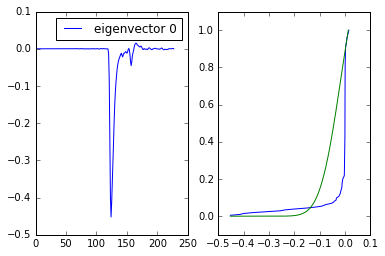

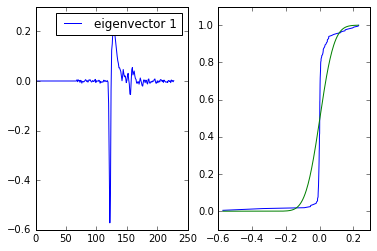

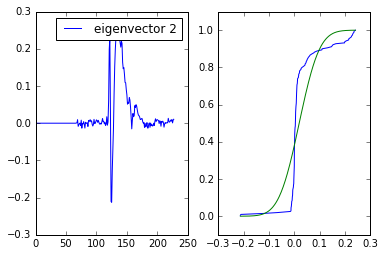

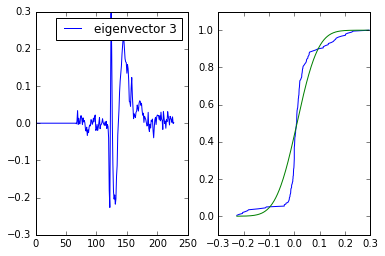

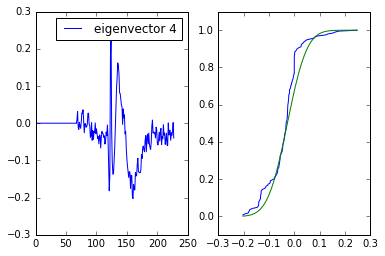

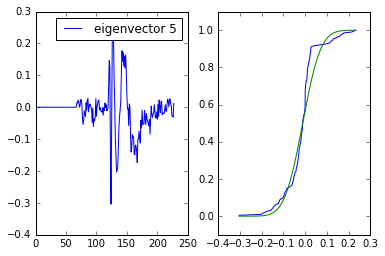

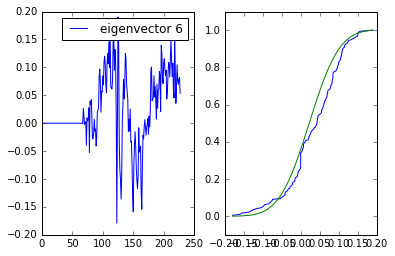

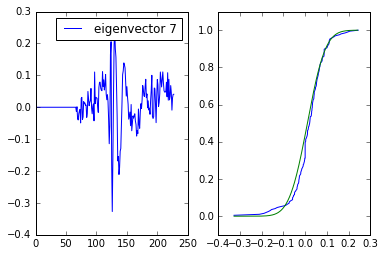

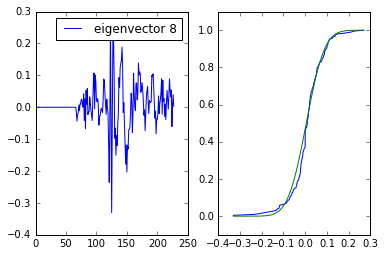

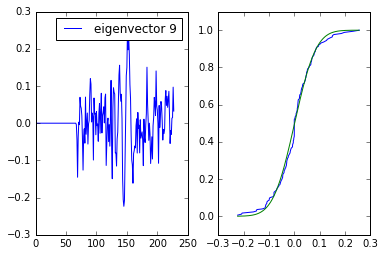

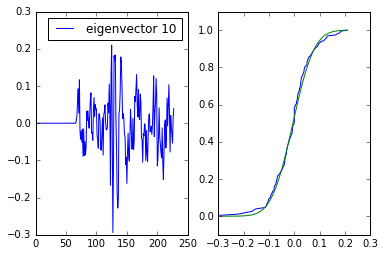

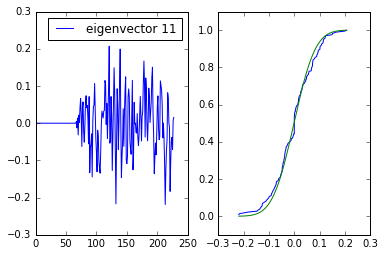

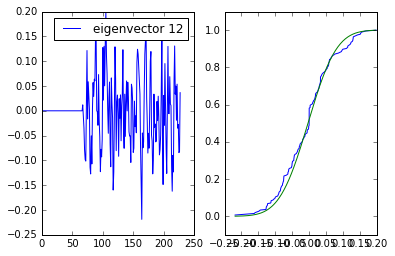

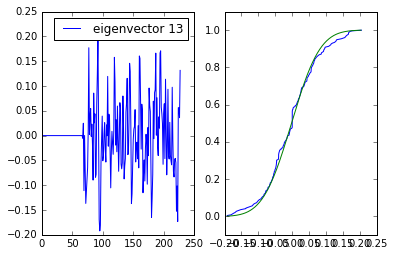

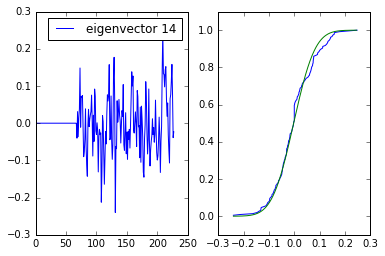

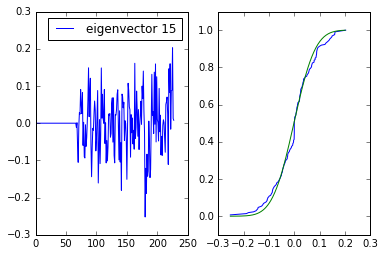

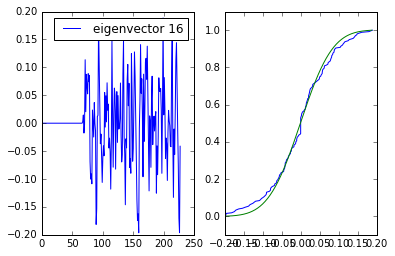

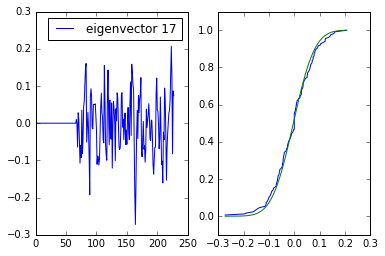

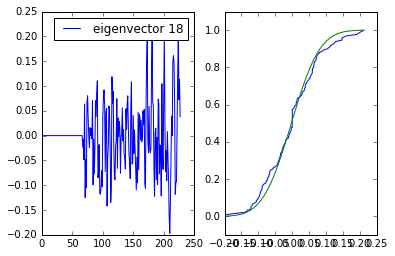

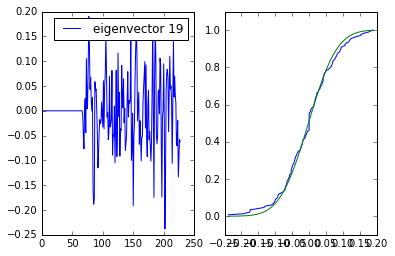

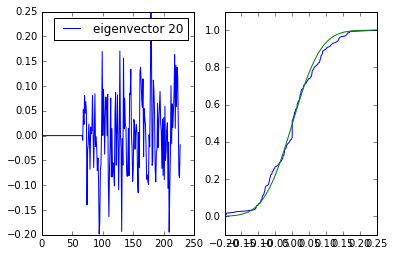

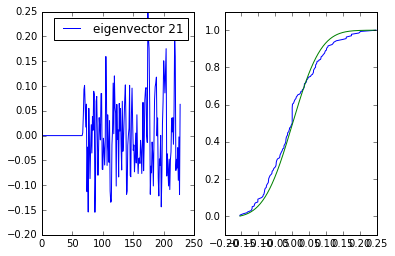

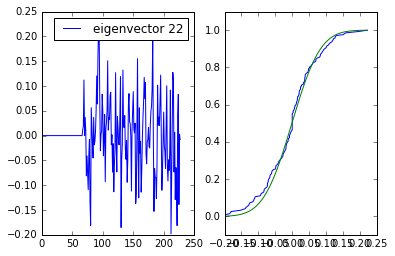

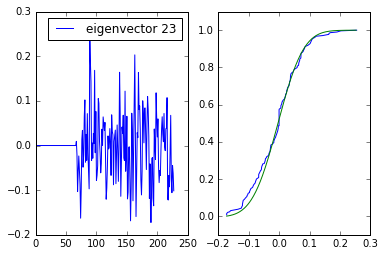

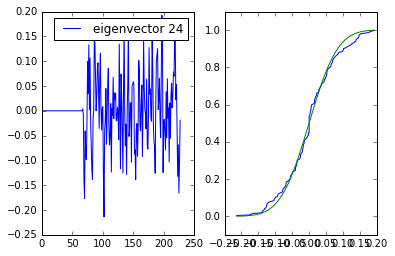

In [14]:
#showing some of the eigen backgrounds
#higher order eigen vectors have gaussian distribution.
#kolmogorov smirnov test isn't implemented accurately here.
#also, anderson-darling and shapiro-wilk test supposed to be more robust
counter = 0
for i in v:
    subplot(121)
    plot(i)
    legend(["eigenvector "+str(counter)])
    
    subplot(122)
    my_edf = cumsum(argsort(i))
    my_edf=my_edf/max(my_edf)
    plot(sort(i),my_edf)
    ylim(-0.1,1.1)
    my_mean = mean(i)
    #my_mean = (max(i)+min(i))/2
    my_std = std(i)
    x = arange(min(i),max(i),(max(i)-min(i))/len(i))
    y = cumsum(exp(-(((x-my_mean)/(2**0.5*my_std))**2)))
    y = y / max(y)
    plot(x,y)
    
    counter = counter+1
    show()


### redoing reconstruction with finesse

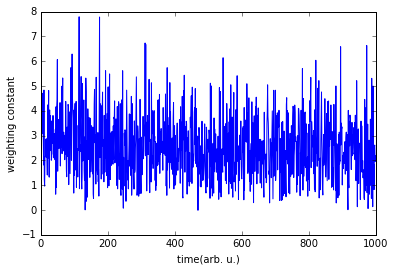

In [53]:
#start,end = (2000,2400)  #which section of waveform to use for svd.  use to select out saturation region
my_mask = ones(ch1_waves.shape[1])
my_mask[122:130]=0
#my_mask[:]=1.0
my_mask = my_mask.astype(bool)

eig_size = 10

#calculating and showing the weights. x-axis is event number
#my_weights = real(dot(ch1_waves[:,my_mask],v[:6,my_mask].transpose()))
my_weights = []

for i in ch1_waves:

    my_mask = abs(i)<0.9
    pseudo_inv = dot(inv(dot(v[:eig_size,my_mask],v[:eig_size,my_mask].transpose())),v[:eig_size,my_mask])

    #total 
    my_weights.append(dot(pseudo_inv,i[my_mask]))

my_weights = array(my_weights)
                    
plot(my_weights[:,0])#the weight of each event
xlabel("time(arb. u.)")
ylabel("weighting constant")
show()

708


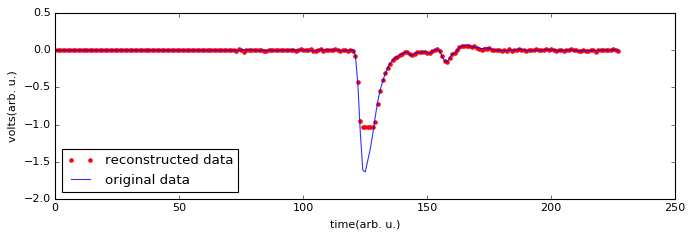

752


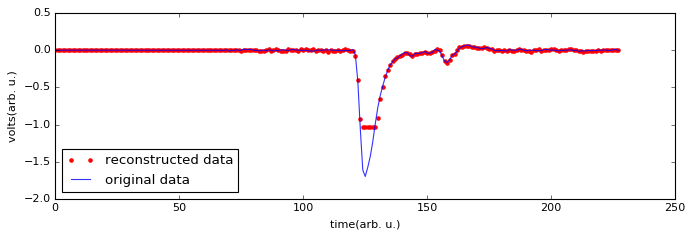

919


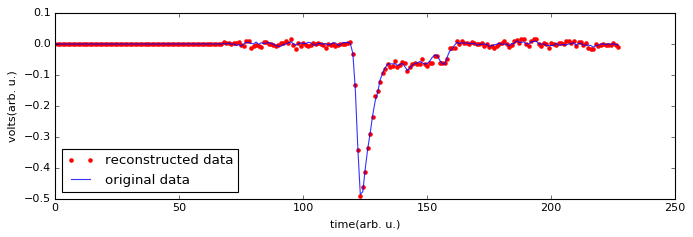

199


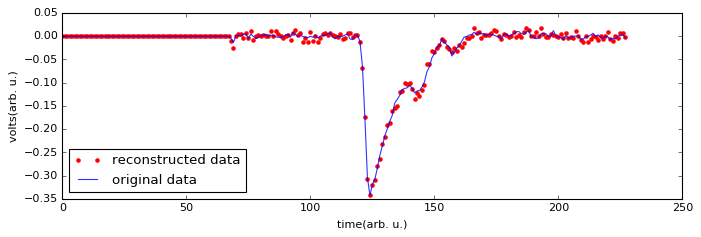

889


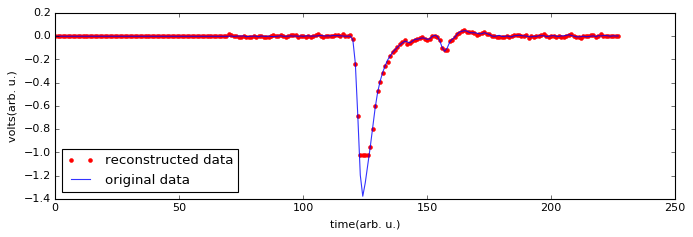

629


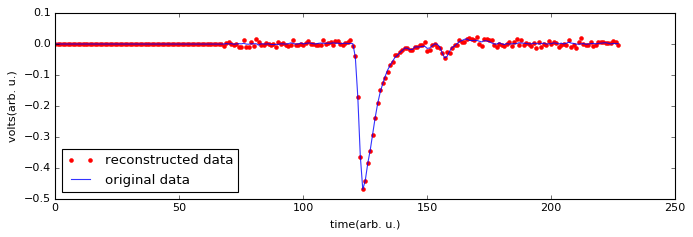

165


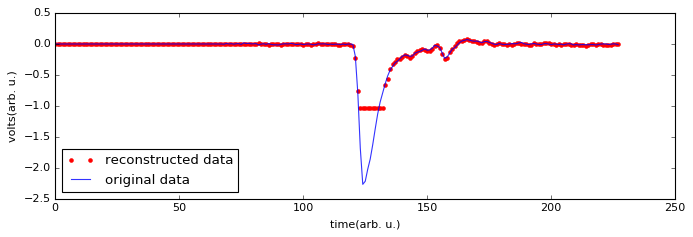

160


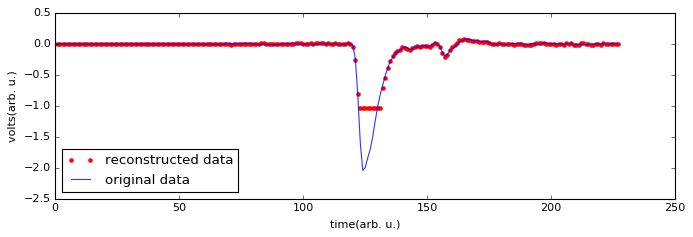

4


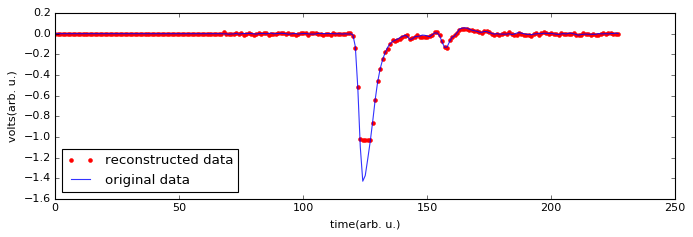

140


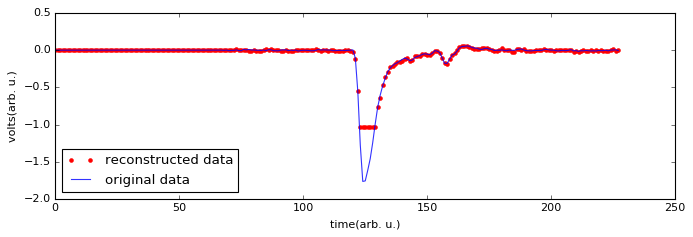

469


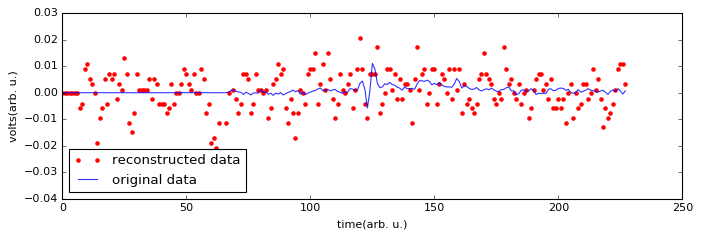

600


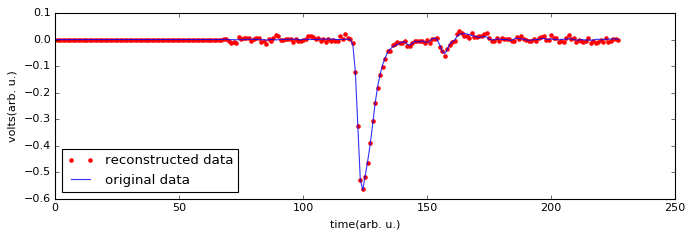

187


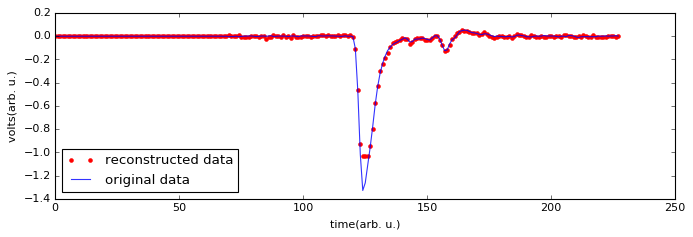

759


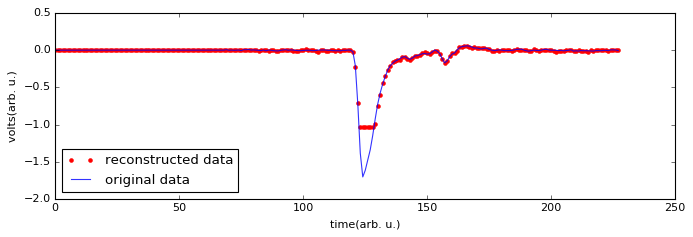

539


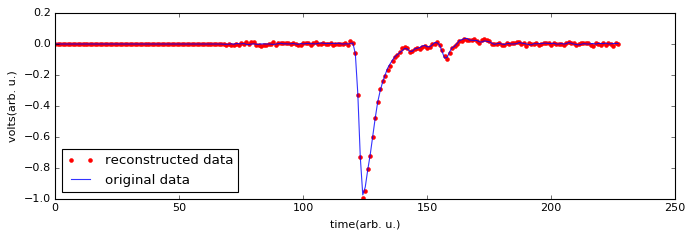

62


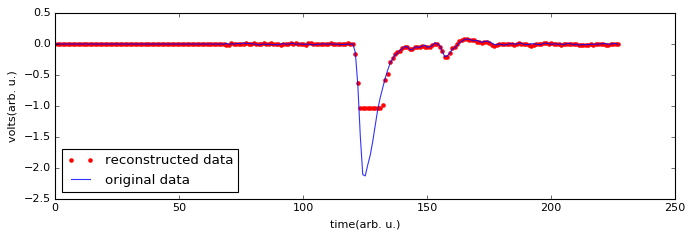

882


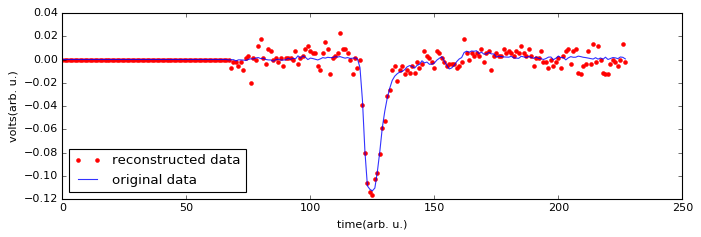

442


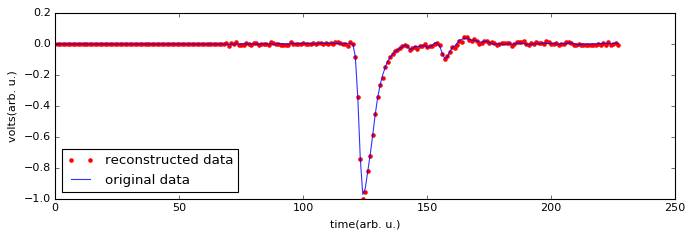

930


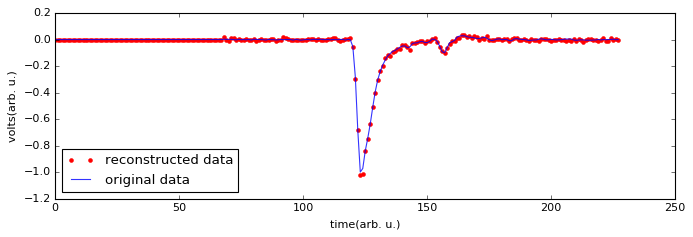

773


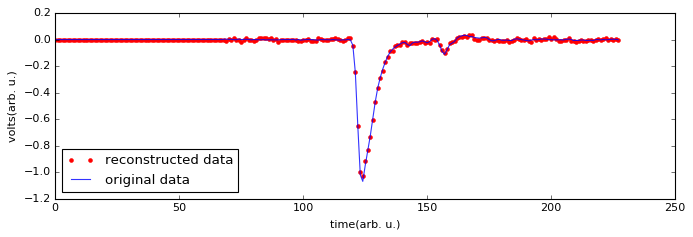

In [186]:
#saturated needs more finesse. doesn't work straight out of the box
for i in (rand(20)*len(my_weights)).astype(int):
    event_to_reconstruct=i
    reconstructed = sum(my_weights[event_to_reconstruct][i]*v[i] for i in arange(eig_size)) #0th waveform calculated from first 5 eigen waveforms
    fig=plt.figure(figsize=(10, 3), dpi= 80, facecolor='w', edgecolor='k')
    plot(ch1_waves[event_to_reconstruct],'r.',markersize=7) #original data set
    plot(reconstructed,'-',alpha=0.8,markersize=9)
    #xlim(3225,3325)
    #xlim(5150,5250)
    xlabel("time(arb. u.)")
    ylabel("volts(arb. u.)")
    legend(['reconstructed data','original data'],loc=3)
    print(i)
    show()

773


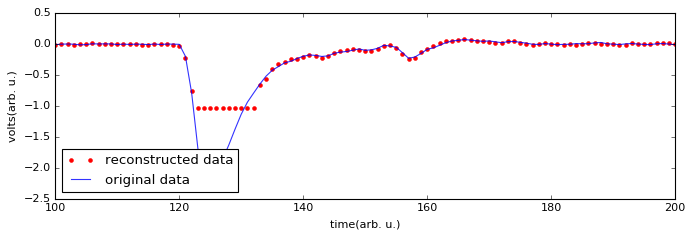

In [189]:
event_to_reconstruct=165
reconstructed = sum(my_weights[event_to_reconstruct][i]*v[i] for i in arange(eig_size)) #0th waveform calculated from first 5 eigen waveforms
fig=plt.figure(figsize=(10, 3), dpi= 80, facecolor='w', edgecolor='k')
plot(ch1_waves[event_to_reconstruct],'r.',markersize=7) #original data set
plot(reconstructed,'-',alpha=0.8,markersize=9)
#xlim(3225,3325)
#xlim(5150,5250)
xlabel("time(arb. u.)")
ylabel("volts(arb. u.)")
legend(['reconstructed data','original data'],loc=3)
xlim(100,200)
print(i)
show()

## Comparing Linearity

### no correction linearity

In [69]:
apd_reconstructed_traces = dot(my_weights,v[:10])


my_edges = array([0,0.5,1,2,3,6,9,12,15,18,21,24,27,30,36,45,55])
mcp_qsum,apd_qsum = sum(mcp_traces**2,axis=1),sum(apd_traces**2,axis=1)


apd_reconstructed_sum = sum(apd_reconstructed_traces**2,axis=1)
my_hist = binned_statistic_dd(mcp_qsum,apd_qsum,bins=[my_edges],statistic=mean)
my_recon_hist = binned_statistic_dd(mcp_qsum,apd_reconstructed_sum,bins=[my_edges],statistic=mean)


In [70]:
my_hist.bin_edges

[array([  0. ,   0.5,   1. ,   2. ,   3. ,   6. ,   9. ,  12. ,  15. ,
         18. ,  21. ,  24. ,  27. ,  30. ,  36. ,  45. ,  55. ])]

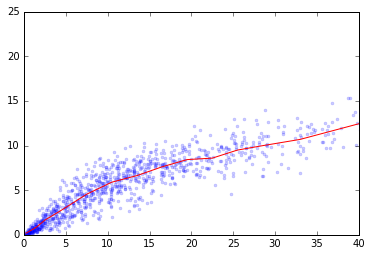

In [71]:
plot(mcp_qsum,apd_qsum,'.',alpha=0.2)
plot((my_hist.bin_edges[0][:-1]+my_hist.bin_edges[0][1:])/2,my_hist.statistic,'r',linewidth=3)
ylim(0,25)
xlim(0,40)
show()

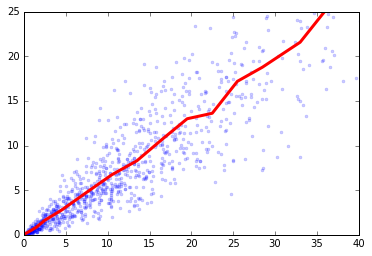

In [76]:
plot(mcp_qsum,apd_reconstructed_sum,'.',alpha=0.2)
plot((my_recon_hist.bin_edges[0][:-1]+my_recon_hist.bin_edges[0][1:])/2,my_recon_hist.statistic,'r',linewidth=3)
ylim(0,25)
xlim(0,40)
show()